In [5]:
import pandas as pd
import pickle
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import save_image
from tqdm.notebook import tqdm

In [6]:
# Connect to the GPU if one exists.
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using: ", device)
torch.cuda.empty_cache()

Using:  cuda


In [7]:
my_seed = 42
random.seed(my_seed)
torch.manual_seed(my_seed)

In [8]:
with open("./rcnn_training_data_transformation_True_step_50_sub_image_size_150.pkl", "rb") as f:
    seal_sub_images = pickle.load(f)

In [9]:
def display_images(image_list, num_images, image_size):
    fig, ax = plt.subplots(ncols=num_images, figsize=(image_size, image_size))
    for idx in range(num_images):
        image = image_list[idx]
        ax[idx].imshow(image)

In [10]:
# Filter out Sub-images below a certain threshold
seal_threshold=.6
filtered_seal_sub_images = []

for image_name in seal_sub_images.keys():
    
    # Extract sub-images anb bounding box information
    sub_image_list, bouding_box_list = seal_sub_images[image_name]
    
    # Filter out sub-images
    for idx in range(len(sub_image_list)):

        # Individual bounding box and sub-image
        bounding_box_data_frame = bouding_box_list[idx]
        sub_image = sub_image_list[idx]

        # Only keep sub-images where atleast one seal is greater than the threshold
        if bounding_box_data_frame.percent.max() >= seal_threshold:
            filtered_seal_sub_images.append(sub_image)


print(f"Sub-images used for training: {len(filtered_seal_sub_images)}")

Sub-images used for training: 54572


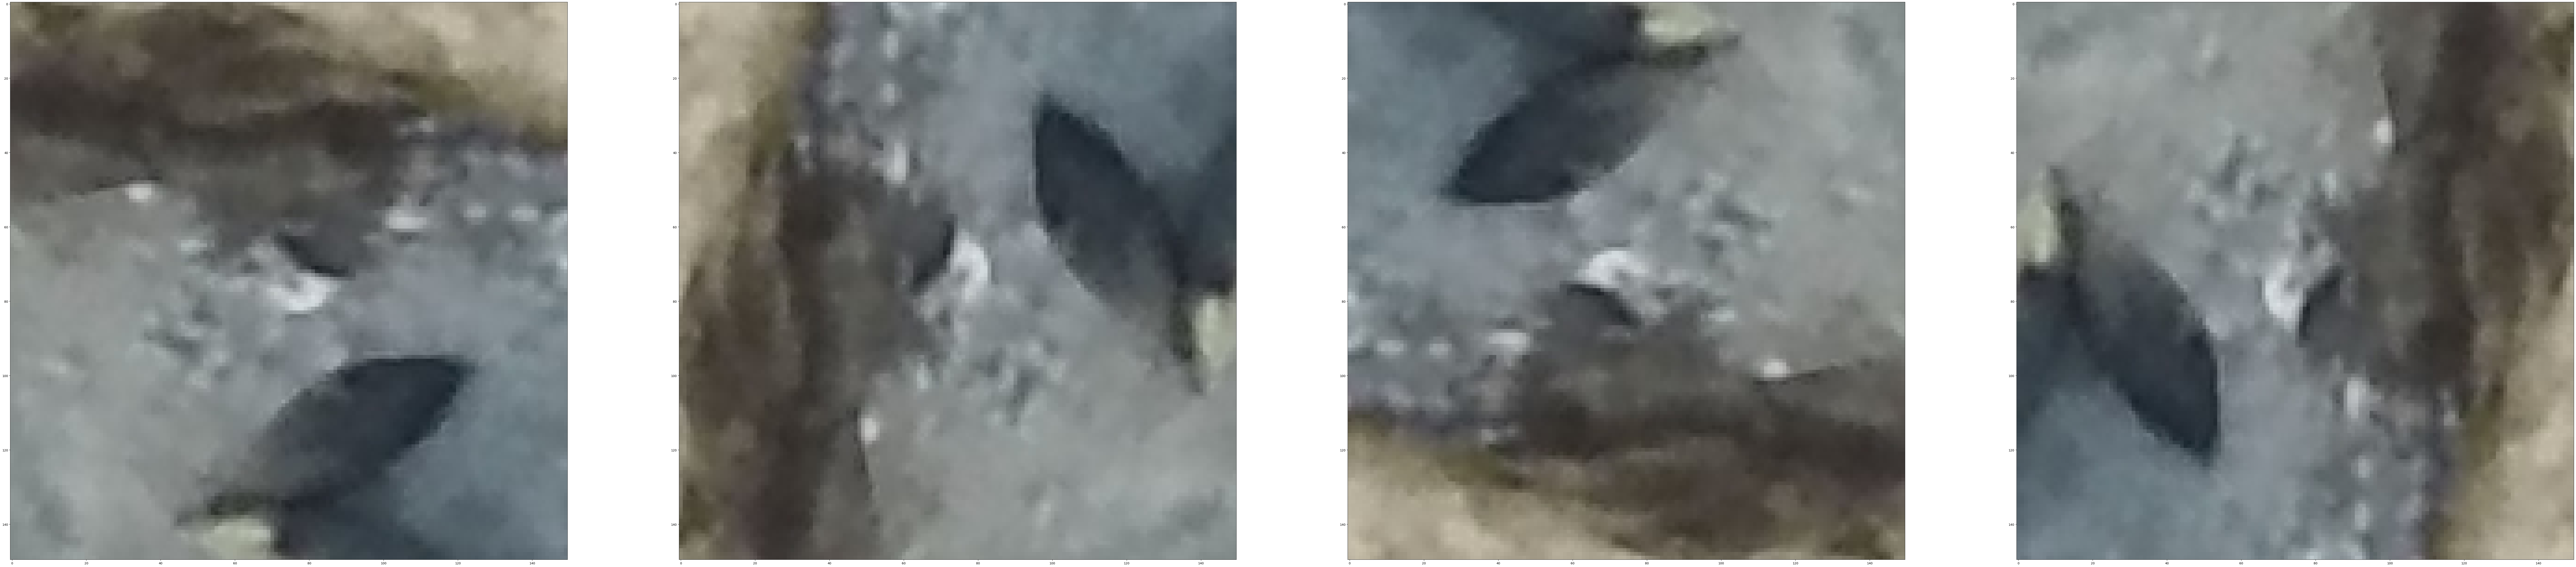

In [11]:
display_images(filtered_seal_sub_images, 4, 150)

In [12]:
# Parameters for DCGAN 
batch_size = 100
image_size = 150
channnels = 3
latent_space = 100
generator_features = 64
discriminator_features = 64
epochs = 50

In [13]:
def initial_weights_normal_dist(layer):
    layer_type = layer.__class__.__name__
    # Layer is convolutional 
    if layer_type.find("Conv") != -1:
        nn.init.normal_(layer.weight.data, 0, .02)
    elif layer_type.find("BatchNorm") != -1:
        nn.init.normal_(layer.weight.data, 1, .02)
        nn.init.constant(layer.bias.data, 0)

In [14]:
class Generator(nn.Module):
    def __init__(self, channels, features, latent_space, image_size):
        super(Generator, self).__init__()
        self.init_size = (image_size // 4) + 1

        self.initial_layer = nn.Sequential(
            nn.Linear(latent_space, 128 * self.init_size ** 2)
        )

        self.convolutional_blocks = nn.Sequential(
            nn.BatchNorm2d(128),

            # Block 1
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128, .8),
            nn.LeakyReLU(.2, inplace=True),

            # Block 2
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, 1, 1),
            nn.BatchNorm2d(64, .8),
            nn.LeakyReLU(.2, inplace=True),

            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )


    def forward(self, input):
        noise_imgs = self.initial_layer(input)

        # Reshape 
        noise_imgs = noise_imgs.view(noise_imgs.shape[0], 128, self.init_size, self.init_size)

        # Generate Images
        generated_imgs = self.convolutional_blocks(noise_imgs)

        # Shave off 2 pixels from the end so the image size is 150x150
        return generated_imgs[:, :, :-2, :-2]
    
    
class Discriminator(nn.Module):
    def __init__(self, channnels, image_size):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            block = [
                nn.Conv2d(in_filters, out_filters, 3, 2, 1),
                nn.LeakyReLU(.2, inplace=True),
                nn.Dropout2d(.4),
            ]

            if normalization:
                block.append(nn.BatchNorm2d(out_filters, .8))
            
            return block
                
        self.model = nn.Sequential(
            *discriminator_block(channnels, 16, False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
            nn.Flatten(),
            nn.Dropout2d(.4),
            nn.Linear(12800, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.model(input)

In [15]:
class SealDataset(Dataset):
    def __init__(self, images, transform=transforms.Compose([transforms.ToTensor()])):
        self.images = images
        self.transform = transform

    def __len__(self):
        self.length = len(self.images)
        return self.length

    def __getitem__(self, idx):
        image = self.images[idx]
        return self.transform(image)

In [16]:
# Create Data Loader
training_data = SealDataset(filtered_seal_sub_images)
training_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

In [17]:
# Initialize models, loss, and optimizers
gan_loss = torch.nn.BCELoss().to(device)

generator = Generator(channnels, generator_features, latent_space, 150).to(device)
discriminator = Discriminator(channnels, image_size).to(device)

generator.apply(initial_weights_normal_dist)
discriminator.apply(initial_weights_normal_dist)

generator_opt = torch.optim.Adam(generator.parameters(), lr=.0001)
discriminator_opt = torch.optim.Adam(discriminator.parameters(), lr=.00001)

C:\Users\kaanan\AppData\Local\Temp\ipykernel_100\299896086.py:8: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(layer.bias.data, 0)


In [18]:
checkpoints = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
model_name = "seal_gan_version_1"
directory_name = f"{model_name}_generated_images"

if directory_name not in os.listdir():
    os.makedirs(f"./{directory_name}")

In [26]:
for epoch in range(epochs):
    batch_num = 0
    prog_bar = tqdm(total= len(training_loader))

    for batch in training_loader:
        '''
        ---------------------------------------------------------------
        Initialize Data
        ---------------------------------------------------------------
        '''

        real_images = batch.to(device)
        noise = torch.randn((batch_size, latent_space)).to(device)
        generated_images = generator(noise)

        '''
        ---------------------------------------------------------------
        Train Discriminator
        ---------------------------------------------------------------
        '''
        
        discriminator_opt.zero_grad()

        # Get predictions on Real
        real_predictions = discriminator(real_images)
        real_labels = torch.ones(real_predictions.shape).to(device)

        # Get predictions on fake
        fake_predictions = discriminator(generated_images)
        fake_labels = torch.zeros(fake_predictions.shape).to(device)
    
        # Combine
        total_predictions = torch.cat((real_predictions, fake_predictions))
        total_labels = torch.cat((real_labels, fake_labels))

        # Backprop
        discriminator_loss = gan_loss(total_predictions, total_labels)
        discriminator_loss.backward()
        discriminator_opt.step()

        '''
        ---------------------------------------------------------------
        Train Generator
        ---------------------------------------------------------------
        '''

        generator_opt.zero_grad()
        
        # 0 for discriminator is 1 for generator
        generator_labels = torch.ones(fake_predictions.shape, requires_grad=True).to(device)
        fake_predictions = discriminator(generated_images).detach()
        generator_loss = gan_loss(fake_predictions, generator_labels)
        generator_loss.backward()
        generator_opt.step()

        '''
        ---------------------------------------------------------------
        Display Results
        ---------------------------------------------------------------
        '''
        prog_bar.update(batch_num)
        prog_bar.set_description(f"Epoch: {epoch + 1} Discriminator Loss: {discriminator_loss} Generator Loss: {generator_loss}")
        prog_bar.refresh()

        batch_num += 1 

 
    # Save model
    if epoch + 1 in checkpoints:
        # Save Generator
        torch.save(
            generator.state_dict(),
            f"./Models/generator_{model_name}_epoch_{epoch+1}"
        )

        # Save Discriminator
        torch.save(
            discriminator.state_dict(),
            f"./Models/discriminator_{model_name}_epoch_{epoch+1}"
        )

    # Generate Sample images
    with torch.no_grad():
        fake_samples = generator(torch.randn(64, latent_space).to(device))
        fake_samples = fake_samples.view(fake_samples.size(0), channnels, image_size, image_size)
        save_image(fake_samples, f"{directory_name}/generated_images_epoch_{epoch+1}.png", normalize=True)


  0%|          | 0/546 [00:00<?, ?it/s]

c:\Users\kaanan\anaconda3\envs\synthetic_seals\lib\site-packages\torch\nn\functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


KeyboardInterrupt: 